In [162]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, cohen_kappa_score, mean_squared_error, confusion_matrix
from sklearn.naive_bayes import MultinomialNB

In [163]:
df= pd.read_csv("C:\\Users\\ADMIN\\OneDrive\\Desktop\\downsampled_reviews.csv")
df

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,B000MUWROU,"Wall Street Journal Edition, Standard Edition",NaN,AV7L6OIWSYWV2,"Julie M. Chung ""JMC""",1/8,1.0,1306454400,Collegebooksdirect,This rating has nothing to do with the book it...
1,B000MZ8P7S,CHANGE Of COMMAND.,NaN,NaN,NaN,4/4,1.0,945129600,Change of Command,I'm *so* glad that my local library had this b...
2,B000J409QW,Sister Carrie,NaN,A3RGCBO2FKD786,Andrew Whitman,3/4,1.0,1335916800,Sometimes Free is Too Expensive,Sometimes free is too expensive. A brief sampl...
3,B000N649VC,Sphere,NaN,A6H0N6D7KMVPM,liammail@optusnet.com.au,3/5,1.0,933552000,Utterly dire...stuff for 10 year olds.,This book is the first Crichton I've read and ...
4,B000NQM9CI,The Stand: The Complete and Uncut Edition (ISB...,NaN,NaN,NaN,14/37,1.0,1072569600,"Overwrought,Overlong, Silly, End of the World ...",As with all of Stephen King's epic novel's the...
...,...,...,...,...,...,...,...,...,...,...
24995,1597370045,The Picture of Dorian Gray (Classic Collection...,87.25,A1BE1OKY80FUBH,Pink Panther,1/1,5.0,1172275200,One of the best,The Picture of Dorian Gray is one the masterpi...
24996,1566044634,The Comprehensive Guide to Lingo: Creating Int...,49.99,AYRL0GZ168OZC,Manuel Gutierrez,0/0,5.0,966816000,Great Book,Nothing like this book in the market. This boo...
24997,B00072QUO6,Zen training: Methods and philosophy,NaN,A3VQIDI2794BBZ,D. A. Waterman,5/5,5.0,1159488000,Best zen book I've ever read,I learned to do zazen from this book a long ti...
24998,B000MUBEFI,"Beginning Java Objects: From Concepts To Code,...",NaN,AGYPM02ESOEHZ,W Brandes,8/9,5.0,1020124800,Excellent book for explaining the O-O paradigm,This book enabled me to understand O-O concept...


# EXPLORATORY DATA ANALYSIS

In [165]:
df.isna().sum()

Id                        0
Title                     2
Price                 21082
User_id                4838
profileName            4838
review/helpfulness        0
review/score              0
review/time               0
review/summary            4
review/text               0
dtype: int64

In [166]:
df_relevant = df[['review/score','review/text']].copy()
df_relevant.info()
print(df['review/score'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   review/score  25000 non-null  float64
 1   review/text   25000 non-null  object 
dtypes: float64(1), object(1)
memory usage: 390.8+ KB
review/score
1.0    5000
2.0    5000
3.0    5000
4.0    5000
5.0    5000
Name: count, dtype: int64


In [167]:
#Reducing the sample size for rating 3.0 to maintain balance as it is somewhat neutral and hence will confuse the model
# Separate rows with review/score of 3.0
rows_3 = df_relevant[df_relevant['review/score'] == 3.0]

# Randomly sample 1000 rows with review/score of 3.0
rows_3_sampled = rows_3.sample(n=1000, random_state=23316144)

# Select the remaining rows that are not 3.0
rows_not_3 = df_relevant[df_relevant['review/score'] != 3.0]

# Concatenate the sampled 3.0 rows with the non-3.0 rows
df_relevant = pd.concat([rows_not_3, rows_3_sampled])

# Reset the index
df_relevant.reset_index(drop=True, inplace=True)

In [168]:
#This step is for Data preparation but was done in EDA to explore only the meaningful data.
import re

# Function to check if a review is written in English
def is_english(text):
    # Check if the text contains only English alphabets, numbers, and common punctuation
    return bool(re.match(r'^[a-zA-Z0-9\s.,!?\'"-]+$', text))

# Apply the filter to the 'review/text' column
df_relevant['is_english'] = df_relevant['review/text'].apply(is_english)

# Filter out non-English reviews
df_english = df_relevant[df_relevant['is_english']]

# Drop the helper column if not needed
df_english = df_english.drop(columns=['is_english'])

# Check the resulting dataset
print(f"Original dataset size: {df_relevant.shape}")
print(f"Filtered dataset size: {df_english.shape}")

Original dataset size: (21000, 3)
Filtered dataset size: (10525, 2)


In [169]:
#This step is for Data preparation but was done in EDA to explore only the meaningful data.
# Classifying the review score [Positive, Neutral, Negative]
def classify_sentiment(score):
    if score >= 3.0:
        return 'Positive'
    else:
        return 'Negative'

# Apply the classification function to the 'review/score' column
df_english['sentiment'] = df_english['review/score'].apply(classify_sentiment)

# Check the distribution of sentiments
print(df_english['sentiment'].value_counts())


sentiment
Positive    5857
Negative    4668
Name: count, dtype: int64


In [170]:
# Create a table summarizing reviews with their sentiment
summary_table = df_english[['sentiment', 'review/text']].copy()
print(summary_table)

      sentiment                                        review/text
0      Negative  This rating has nothing to do with the book it...
3      Negative  This book is the first Crichton I've read and ...
6      Negative  Not worth the cost of the book. It's only 24-2...
7      Negative  I was going over the options chapter, a very c...
10     Negative  There is nothing valuable about this book any ...
...         ...                                                ...
20990  Positive  it was ok the the heroine charater begin to ge...
20992  Positive  This is certainly not the definitive Bruce bio...
20994  Positive  I read this book years ago, and it gripped me ...
20995  Positive  Just finished "24 Essential Lessons for Invest...
20998  Positive  I wanted to buy a book that would help me appl...

[10525 rows x 2 columns]


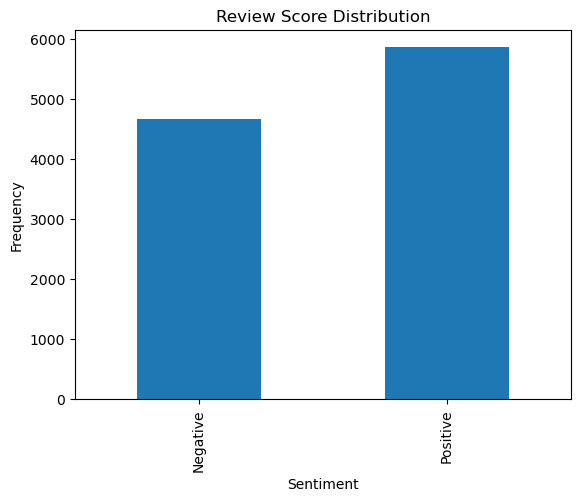

In [171]:
# Plot the distribution of review scores
summary_table['sentiment'].value_counts().sort_index().plot(kind='bar', title='Review Score Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.show()


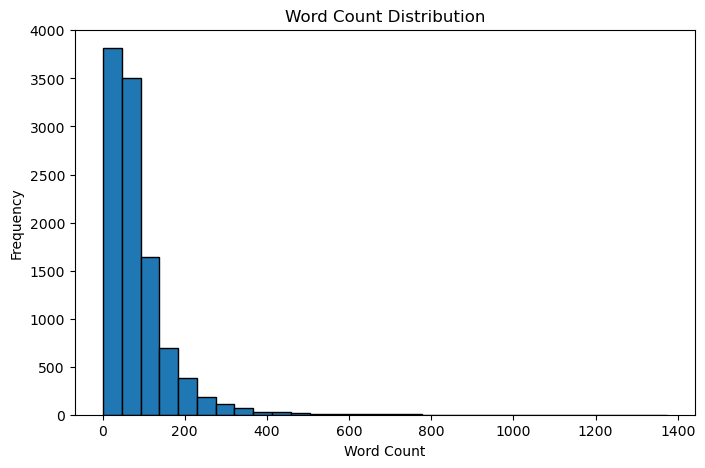

In [172]:
# Calculate word counts for visualization
word_counts = summary_table['review/text'].apply(lambda x: len(x.split()))

# Plot the word count distribution
plt.figure(figsize=(8, 5))
plt.hist(word_counts, bins=30, edgecolor='black')
plt.title('Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()


# DATA PREPARATION

In [174]:
# Initialize stop words and punctuation
stop_words = set(stopwords.words('english'))

# Preprocessing function using NLTK
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stop words
    tokens = [word for word in tokens if word not in stop_words]
    # Join tokens back to a string
    return ' '.join(tokens)

# Apply preprocessing to the 'review/text' column
summary_table['review/text'] = summary_table['review/text'].apply(preprocess_text)

# Display a few rows to verify the changes
print(summary_table['review/text'].head())


0     rating nothing book reflection low quality sel...
3     book first crichton ive read absolutely last w...
6     worth cost book 2428 pages long merely recap j...
7     going options chapter critical part series 7 m...
10    nothing valuable book except table contents mi...
Name: review/text, dtype: object


In [175]:
#Vectorization
# Initialize TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed

# Apply TF-IDF transformation to the preprocessed text
X = vectorizer.fit_transform(summary_table['review/text'])

# Display the shape of the resulting TF-IDF matrix
print(f"TF-IDF matrix shape: {X.shape}")

TF-IDF matrix shape: (10525, 5000)


In [176]:
#Splitting the dataset 80-20

X_train, X_test, y_train, y_test = train_test_split(X, summary_table['sentiment'], test_size=0.2, random_state=42)

# Verify the sizes of the splits
print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")


Training set size: (8420, 5000)
Testing set size: (2105, 5000)


In [177]:
# Encode the target variable
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

# Check the mapping
print("Class mapping:", dict(enumerate(encoder.classes_)))

Class mapping: {0: 'Negative', 1: 'Positive'}


# MODELLING

1)Logistic Regression

In [179]:
# Train a logistic regression model
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model: Accuracy and Classification Report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=encoder.classes_))

# Cohen's Kappa
kappa = cohen_kappa_score(y_test, y_pred)
print("\nCohen's Kappa:", kappa)

# RMSE (Root Mean Squared Error)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE:", rmse)

# RSS (Residual Sum of Squares)
rss = ((y_test - y_pred) ** 2).sum()
print("RSS:", rss)


Accuracy: 0.8137767220902613

Classification Report:
              precision    recall  f1-score   support

    Negative       0.82      0.74      0.78       935
    Positive       0.81      0.87      0.84      1170

    accuracy                           0.81      2105
   macro avg       0.82      0.81      0.81      2105
weighted avg       0.81      0.81      0.81      2105


Cohen's Kappa: 0.6190889451040493
RMSE: 0.43153595204772766
RSS: 392


C:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2)Naive Bayes

In [181]:
# Initialize the Naive Bayes model
nb_model = MultinomialNB()

# Train the model on the training data
nb_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_nb = nb_model.predict(X_test)

# Model Evaluation
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print("\nClassification Report for Naive Bayes:")
print(classification_report(y_test, y_pred_nb, target_names=encoder.classes_))

# Cohen's Kappa
kappa_nb = cohen_kappa_score(y_test, y_pred_nb)
print("\nCohen's Kappa for Naive Bayes:", kappa_nb)

# RMSE (Root Mean Squared Error)
rmse_nb = mean_squared_error(y_test, y_pred_nb, squared=False)
print("RMSE for Naive Bayes:", rmse_nb)

# RSS (Residual Sum of Squares)
rss_nb = ((y_test - y_pred_nb) ** 2).sum()
print("RSS for Naive Bayes:", rss_nb)

Naive Bayes Accuracy: 0.804750593824228

Classification Report for Naive Bayes:
              precision    recall  f1-score   support

    Negative       0.83      0.71      0.76       935
    Positive       0.79      0.88      0.83      1170

    accuracy                           0.80      2105
   macro avg       0.81      0.80      0.80      2105
weighted avg       0.81      0.80      0.80      2105


Cohen's Kappa for Naive Bayes: 0.5987547392952799
RMSE for Naive Bayes: 0.4418703499622621
RSS for Naive Bayes: 411


C:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


3) Random Forest Claasifier

In [183]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=23316144, class_weight='balanced')

# Train the model on the training data
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model: Accuracy and Classification Report
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report for Random Forest:")
print(classification_report(y_test, y_pred_rf, target_names=encoder.classes_))

# Cohen's Kappa
kappa_rf = cohen_kappa_score(y_test, y_pred_rf)
print("\nCohen's Kappa for Random Forest:", kappa_rf)

# RMSE (Root Mean Squared Error)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
print("RMSE for Random Forest:", rmse_rf)

# RSS (Residual Sum of Squares)
rss_rf = ((y_test - y_pred_rf) ** 2).sum()
print("RSS for Random Forest:", rss_rf)

Random Forest Accuracy: 0.7833729216152019

Classification Report for Random Forest:
              precision    recall  f1-score   support

    Negative       0.78      0.71      0.75       935
    Positive       0.79      0.84      0.81      1170

    accuracy                           0.78      2105
   macro avg       0.78      0.78      0.78      2105
weighted avg       0.78      0.78      0.78      2105


Cohen's Kappa for Random Forest: 0.5575713159750549
RMSE for Random Forest: 0.4654321415467545
RSS for Random Forest: 456


C:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
